# Routing, speed imputation, and travel times

Including parallelized shortest-path solving via built-in multiprocessing in OSMnx.

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://geoffboeing.com/publications/osmnx-paper/)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)

In [1]:
pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.3 MB/s eta 0:00:00


In [2]:
import multiprocessing as mp

import numpy as np
import osmnx as ox

np.random.seed(0)
ox.__version__

'2.0.1'

In [3]:
place = "Piedmont, California, USA"
G = ox.graph.graph_from_place(place, network_type="drive")
Gp = ox.projection.project_graph(G)

## 1. Fast nearest node/edge search with OSMnx

The nearest_nodes and nearest_edges functions take arrays of x and y (or lng/lat) coordinates and return the nearest node/edge to each.

In [4]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.convert.to_undirected(Gp), n=100)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

In [5]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.distance.nearest_nodes(Gp, X, Y, return_dist=True)

In [6]:
# or, find the nearest node to a single point
node = ox.distance.nearest_nodes(Gp, X0, Y0)
node

53085377

In [7]:
# find each nearest edge to several points, and optionally return distance
edges, dists = ox.distance.nearest_edges(Gp, X, Y, return_dist=True)

In [8]:
# find the nearest edge to a single point
edge = ox.distance.nearest_edges(Gp, X0, Y0)
edge

(53085377, 53085375, 0)

## 2. Basic routing by distance

Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

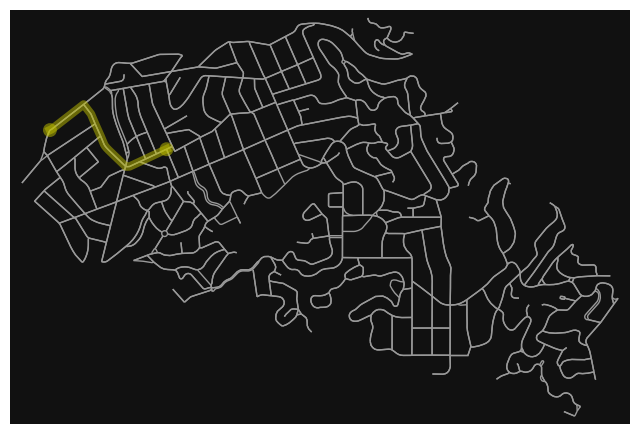

In [9]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G)[0]
dest = list(G)[120]
route = ox.routing.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

Or get *k* shortest paths, weighted by some attribute:

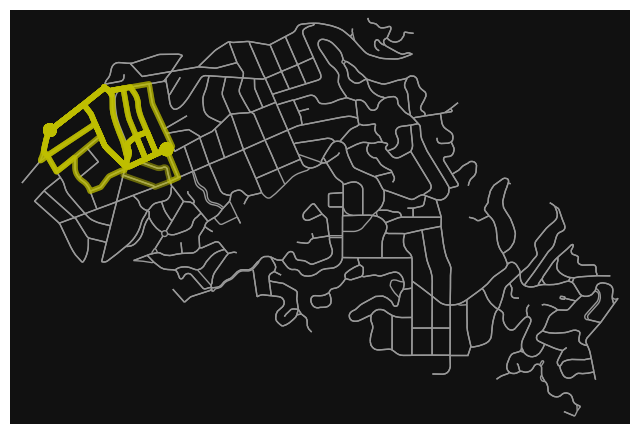

In [10]:
routes = ox.routing.k_shortest_paths(G, orig, dest, k=30, weight="length")
fig, ax = ox.plot.plot_graph_routes(
    G, list(routes), route_colors="y", route_linewidth=4, node_size=0
)

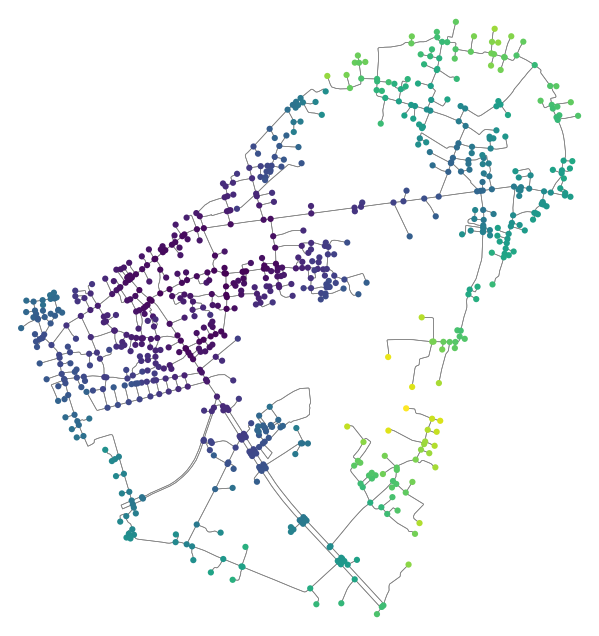

In [17]:
import networkx as nx
import osmnx as ox
import numpy as np

# Load graph (use your own city or area)
place = "Hiep Hoa, Bien Hoa, Vietnam"
G = ox.graph_from_place(place, network_type="walk")  # Change to 'drive' for car networks

# Get all node IDs in the graph
nodes = list(G.nodes)

# Dictionary to store remoteness scores
remoteness_scores = {}

# Calculate average shortest path length for each node
for node in nodes:
    lengths = nx.single_source_dijkstra_path_length(G, node, weight="length")
    remoteness_scores[node] = np.mean(list(lengths.values()))  # Average path length

# Normalize scores for better visualization
max_remoteness = max(remoteness_scores.values())
for node in remoteness_scores:
    remoteness_scores[node] /= max_remoteness  # Normalize between 0 and 1

# Visualizing the remoteness scores
node_colors = [remoteness_scores[n] for n in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,
    node_size=20,
    edge_linewidth=0.5,
    edge_color="gray",  # Optional for better visualization
    bgcolor="white",  # Background color
    show=True
)


In [22]:
import pandas as pd

# Convert dictionary to DataFrame
df = pd.DataFrame(remoteness_scores.items(), columns=["Node", "Remoteness"])

# Save to CSV
df.to_csv("remoteness_scores.csv", index=False)

print("Remoteness scores exported successfully to remoteness_scores.csv")


Remoteness scores exported successfully to remoteness_scores.csv


In [20]:
pip install --upgrade osmnx

<ipython-input-24-5749f9854591>:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


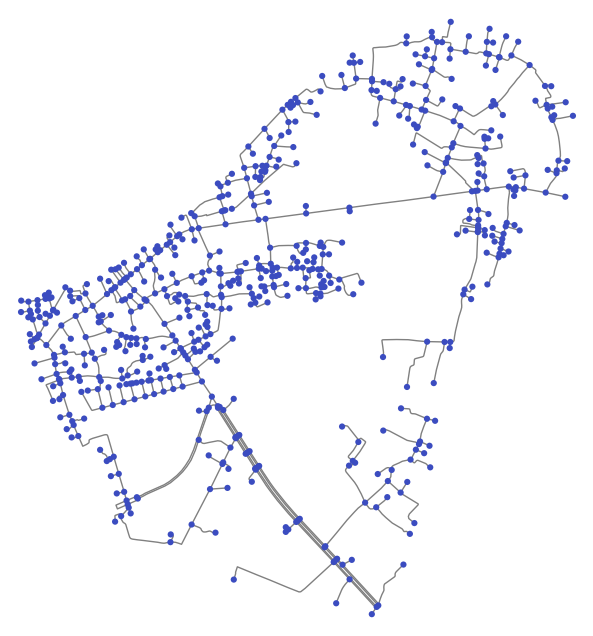

In [24]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.spatial.distance import euclidean

# Load a street network from OpenStreetMap
place_name = "Hiep Hoa, Bien Hoa, Vietnam"
G = ox.graph_from_place(place_name, network_type="drive")

# Convert to undirected to simplify turn calculations
G = G.to_undirected()
# Define turn threshold (20 degrees)
TURN_THRESHOLD = 20
SEARCH_RADIUS = 1000  # Set radius in meters

# Function to calculate turn angles
def compute_turn_angle(bearing1, bearing2):
    turn_angle = abs(bearing1 - bearing2)
    return min(turn_angle, 360 - turn_angle)

# Function to determine turn penalty
def count_turns_along_path(path):
    turn_count = 0
    for i in range(1, len(path) - 1):
        u, v, w = path[i - 1], path[i], path[i + 1]

        if G.has_edge(u, v) and G.has_edge(v, w):
            edge1 = G[u][v][0]
            edge2 = G[v][w][0]

            bearing1 = edge1.get("bearing", 0)
            bearing2 = edge2.get("bearing", 0)

            turn_angle = compute_turn_angle(bearing1, bearing2)

            # Count turns at intersections only
            if turn_angle > TURN_THRESHOLD and len(list(G.neighbors(v))) > 2:
                turn_count += 1
    return turn_count

# Compute Turns Remoteness
remoteness_scores = {}
for node in G.nodes():
    total_turns = 0
    reachable_nodes = 0

    for target in G.nodes():
        if node == target:
            continue
        try:
            # Check if within radius
            if euclidean((G.nodes[node]["y"], G.nodes[node]["x"]),
                         (G.nodes[target]["y"], G.nodes[target]["x"])) > SEARCH_RADIUS:
                continue

            path = nx.shortest_path(G, node, target, weight="length")
            turns = count_turns_along_path(path)

            total_turns += turns
            reachable_nodes += 1
        except:
            continue

    # Average turns over reachable nodes
    remoteness_scores[node] = total_turns / reachable_nodes if reachable_nodes > 0 else 0

# Normalize for visualization
norm = colors.Normalize(vmin=min(remoteness_scores.values()), vmax=max(remoteness_scores.values()))
cmap = cm.get_cmap("coolwarm")
node_colors = [cmap(norm(remoteness_scores[n])) for n in G.nodes()]

# Plot the graph with remoteness visualization
fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,
    node_size=20,
    edge_color="gray",
    bgcolor="white",
    show=True
)


## 3. Imputing travel speeds and times

The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [ ]:
# impute speed on all edges missing data
G = ox.routing.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.routing.add_edge_travel_times(G)

In [ ]:
# see mean speed/time values by road type
edges = ox.convert.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

In [ ]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.routing.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.routing.add_edge_travel_times(G)

In [ ]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.routing.shortest_path(G, orig, dest, weight="length")
route2 = ox.routing.shortest_path(G, orig, dest, weight="travel_time")

In [ ]:
# plot the routes
fig, ax = ox.plot.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [ ]:
# compare the two routes
route1_length = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["length"]))
route2_length = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["length"]))
route1_time = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["travel_time"]))
route2_time = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["travel_time"]))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

The yellow route minimizes travel time, and is thus longer but faster than the red route.

For more examples of travel time, see the [isochrones example](13-isolines-isochrones.ipynb).

For more examples of routing, including using elevation as an impedance, see the [elevations example](12-node-elevations-edge-grades.ipynb).

## 4. Multiprocessing

Calculating lots of shortest paths can be slow, but OSMnx has built-in shortest path solver parallelization and multiprocessing. With the `shortest_path` function, you can pass in a single origin-destination pair to solve the one shortest path, or you can pass in lists of origins and destinations to solve each shortest path between the pairs. If you're solving shortest paths for multiple origins/destinations, the `cpus` argument determines how many CPU cores to utilize for parallelized solving. Multiprocessing adds some overhead, so it's only faster if you're solving a lot of paths. It also has substantial RAM requirements (as it must copy the graph into each sub-process), so be careful with your RAM when setting the `cpus` argument.

In [ ]:
# calculate 100,000 shortest-path routes using random origin-destination pairs
n = 100000
origs = np.random.choice(G.nodes, size=n, replace=True)
dests = np.random.choice(G.nodes, size=n, replace=True)

In [ ]:
# how many CPUs do you have
mp.cpu_count()

In [ ]:
# %%time
# it takes 2.3 seconds to solve all the routes using all the cores on my computer
# I have a 24-thread AMD 5900x: performance will depend on your specific CPU
# routes = ox.routing.shortest_path(G, origs, dests, weight="travel_time", cpus=None)

In [ ]:
%%time
# it takes 29 seconds to solve all the routes using just 1 core on my computer
routes = ox.routing.shortest_path(G, origs, dests, weight="travel_time", cpus=1)

In [ ]:
# how many total results did we get
print(len(routes))

# and how many were solvable paths
# some will be unsolvable due to directed graph perimeter effects
routes_valid = [r for r in routes if r is not None]
print(len(routes_valid))

## 5. Miscellaneous routing notes

The routing correctly handles one-way streets:

In [ ]:
G2 = ox.graph.graph_from_address(
    "N. Sicily Pl., Chandler, Arizona",
    dist=800,
    network_type="drive",
    truncate_by_edge=True,
)
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.routing.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot.plot_graph_route(G2, route, route_color="c", node_size=0)

Also, when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot:

In [ ]:
location_point = (33.299896, -111.831638)
G2 = ox.graph.graph_from_point(location_point, dist=400, truncate_by_edge=True)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.routing.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot.plot_graph_route(G2, route, route_color="c", node_size=0)